### Fetching the data

In [1]:
import sys
import os

# Add parent directory (where 'src' is located) to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
from src import datacleaning_prep as dcp
from src import franchise_analysis as franch
from src import kpi_analysis as kpi
from src import visualisation as visn

In [3]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
file_path='/Users/gyauk/github/labs/IMBD_movie_analysis/Project1/data/raw/movies.csv'
df= dcp.load_data(file_path)


In [5]:
df.columns.to_list()


['adult',
 'backdrop_path',
 'belongs_to_collection',
 'budget',
 'genres',
 'homepage',
 'id',
 'imdb_id',
 'origin_country',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'poster_path',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'video',
 'vote_average',
 'vote_count',
 'credits']

## Data Preparation & Cleaning

### Drop Irrelevant Columns

In [6]:
df= df.drop(columns =['adult', 'imdb_id', 'original_title', 'video', 'homepage'])
df.head()


,backdrop_path,belongs_to_collection,budget,genres,id,origin_country,original_language,overview,popularity,poster_path,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,credits
0,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",356000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 878, ...",299534,['US'],en,After the devastating events of Avengers: Infi...,24.2346,/ulzhLuWrPK07P1YkdWQLZnQh1JL.jpg,...,2019-04-24,2799439100,181,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Avenge the fallen.,Avengers: Endgame,8.238,26214,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."
1,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",19995,['US'],en,"In the 22nd century, a paraplegic Marine is di...",32.6950,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,...,2009-12-15,2923706026,162,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Enter the world of Pandora.,Avatar,7.588,32121,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."
2,/k6EOrckWFuz7I4z4wiRwz8zsj4H.jpg,"{'id': 10, 'name': 'Star Wars Collection', 'po...",245000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",140607,['US'],en,Thirty years after defeating the Galactic Empi...,13.1664,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,...,2015-12-15,2068223624,136,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Every generation has a story.,Star Wars: The Force Awakens,7.262,19667,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."
3,/mDfJG3LC3Dqb67AZ52x3Z0jU0uB.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",299536,['US'],en,As the Avengers and their allies have continue...,33.0700,/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg,...,2018-04-25,2052415039,149,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Destiny arrives all the same.,Avengers: Infinity War,8.236,30391,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."
4,/sCzcYW9h55WcesOqA12cgEr9Exw.jpg,NaN,200000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",597,['US'],en,101-year-old Rose DeWitt Bukater tells the sto...,38.6063,/9xjZS2rlVxm8SFx8kPC3aIGCOYQ.jpg,...,1997-11-18,2264162353,194,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Nothing on Earth could come between them.,Titanic,7.905,25869,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."


In [7]:
for col in df.columns:
    print(f"{col}: {type(df[col].iloc[0])}")

backdrop_path: <class 'str'>
belongs_to_collection: <class 'str'>
budget: <class 'numpy.int64'>
genres: <class 'str'>
id: <class 'numpy.int64'>
origin_country: <class 'str'>
original_language: <class 'str'>
overview: <class 'str'>
popularity: <class 'numpy.float64'>
poster_path: <class 'str'>
production_companies: <class 'str'>
production_countries: <class 'str'>
release_date: <class 'str'>
revenue: <class 'numpy.int64'>
runtime: <class 'numpy.int64'>
spoken_languages: <class 'str'>
status: <class 'str'>
tagline: <class 'str'>
title: <class 'str'>
vote_average: <class 'numpy.float64'>
vote_count: <class 'numpy.int64'>
credits: <class 'str'>


### Evaluate JSON Like column

In [8]:
# #Function to convert a string like items to actual python objects which could be list or dictionary 
# def evaluate_json_column(column):
#     try:
#         # checks if value is na otherwise converts to object
#         return ast.literal_eval(column) if pd.notna(column) else {}
#     except (ValueError, SyntaxError):
#         return {}

json_columns = ['belongs_to_collection', 'genres', 'production_countries','production_companies', 'spoken_languages','credits']

# applies the function to the affected columns
# for col in json_columns:
#     df[col] = df[col].apply(dcp.convert_json_columns)


# df.head()

df = dcp.convert_json_columns(df, json_columns)

In [9]:
#checking if above cell worked 
for col in df.columns:
    print(f"{col}: {type(df[col].iloc[0])}")

backdrop_path: <class 'str'>
belongs_to_collection: <class 'dict'>
budget: <class 'numpy.int64'>
genres: <class 'list'>
id: <class 'numpy.int64'>
origin_country: <class 'str'>
original_language: <class 'str'>
overview: <class 'str'>
popularity: <class 'numpy.float64'>
poster_path: <class 'str'>
production_companies: <class 'list'>
production_countries: <class 'list'>
release_date: <class 'str'>
revenue: <class 'numpy.int64'>
runtime: <class 'numpy.int64'>
spoken_languages: <class 'list'>
status: <class 'str'>
tagline: <class 'str'>
title: <class 'str'>
vote_average: <class 'numpy.float64'>
vote_count: <class 'numpy.int64'>
credits: <class 'dict'>


In [10]:
df.columns


Index(['backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'id',
       'origin_country', 'original_language', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'vote_average', 'vote_count', 'credits'],
      dtype='object')

### Extract and clean key data points

In [11]:
# # function to extract name from the  dictionary in the column 
# def extract_collection_name(value):
#     try:
#         if pd.notnull(value) and isinstance(value, dict):
#             return value.get('name')
#     except (ValueError, SyntaxError):
#         return None

# Apply function to the column
df['collection_name'] = df['belongs_to_collection'].apply(dcp.extract_collection_name)


In [12]:
df['collection_name'][0]

'The Avengers Collection'

In [13]:
df['genres'][0]


[{'id': 12, 'name': 'Adventure'},
 {'id': 878, 'name': 'Science Fiction'},
 {'id': 28, 'name': 'Action'}]

In [14]:
# #separate the mutliple keys called name in the dictionary with '|'
# def break_data_points(df, init_column, new_column):
#   df[new_column] = df[init_column].apply(lambda x: ' | '.join(d['name'] for d in x) if isinstance(x, list) else None)
#   return df[new_column]
      
    
dcp.break_data_points(df,'genres','genre_names')
dcp.break_data_points(df, 'production_countries', 'cld_production_countries')
dcp.break_data_points(df, 'production_companies', 'cld_production_companies')
dcp.break_data_points(df, 'spoken_languages', 'original_language')



0                                      English | 日本語 | 
1                                     English | Español
2                                               English
3                                            English | 
4     English | Français | Deutsch | svenska | Itali...
5                                               English
6                                               English
7                            English | हिन्दी | Pусский
8                 العربية | English | Español | ภาษาไทย
9                                               English
10                     English | 한국어/조선말 | Kiswahili | 
11                                              English
12                                              English
13                                              English
14                                    English | Pусский
15                                              English
16                                   English | Français
17                                              

In [15]:
# Extract and add new columns
df['cast'] = df['credits'].apply(lambda x: ' | '.join(dcp.extract_cast_names(x)))
df['crew'] = df['credits'].apply(lambda x: ' | '.join(dcp.extract_crew_names(x)))
df['director'] = df['credits'].apply(dcp.extract_director)
df['cast_size'] = df['credits'].apply(lambda x: len(x.get('cast', [])))
df['crew_size'] = df['credits'].apply(lambda x: len(x.get('crew', [])))


In [16]:
df['cast'].head()
df['crew'].head()
df['director'].head()
df['cast_size'].head()
df['crew_size'].head()

0    593
1    986
2    257
3    724
4    258
Name: crew_size, dtype: int64

In [17]:
df.columns



Index(['backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'id',
       'origin_country', 'original_language', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'revenue', 'runtime', 'spoken_languages', 'status',
       'tagline', 'title', 'vote_average', 'vote_count', 'credits',
       'collection_name', 'genre_names', 'cld_production_countries',
       'cld_production_companies', 'cast', 'crew', 'director', 'cast_size',
       'crew_size'],
      dtype='object')

### Identify Anomalies with value_count()

In [18]:
# # function to pick the value_counts of each specified column
# def get_value_counts(df, column):
#     return df[column].value_counts()
    

In [19]:
dcp.get_value_counts(df, 'genre_names')

genre_names
Adventure | Action | Science Fiction                 3
Action | Adventure | Science Fiction | Thriller      2
Action | Adventure | Science Fiction                 2
Adventure | Science Fiction | Action                 1
Action | Adventure | Fantasy | Science Fiction       1
Drama | Romance                                      1
Adventure | Drama | Family | Animation               1
Science Fiction | Action | Adventure                 1
Action | Thriller | Crime                            1
Fantasy | Adventure                                  1
Family | Animation | Adventure | Comedy | Fantasy    1
Animation | Family | Adventure | Fantasy             1
Family | Fantasy | Romance                           1
Action | Adventure | Animation | Family              1
Name: count, dtype: int64

In [20]:
dcp.get_value_counts(df, 'cld_production_countries')

cld_production_countries
United States of America                     16
United States of America | United Kingdom     1
United Kingdom | United States of America     1
Name: count, dtype: int64

In [21]:
dcp.get_value_counts(df, 'original_language')

original_language
English                                                        9
English | 日本語 |                                                1
English | Español                                              1
English |                                                      1
English | Français | Deutsch | svenska | Italiano | Pусский    1
English | हिन्दी | Pусский                                     1
العربية | English | Español | ภาษาไทย                          1
English | 한국어/조선말 | Kiswahili |                                1
English | Pусский                                              1
English | Français                                             1
Name: count, dtype: int64

In [22]:
# # 
# def normalize_anomalies(genre_string):
#     # converts the split genres names to a list and sorts them and returns them to have them be unique
#     genres = list(genrestring.strip() for genrestring in genre_string.split('|'))
#     sorted_genres = sorted(genres)
#     return ' | '.join(sorted_genres)

df['genre_names']= df['genre_names'].apply(dcp.normalize_anomalies)
df['cld_production_countries']= df['cld_production_countries'].apply(dcp.normalize_anomalies)
df['cld_production_companies']= df['cld_production_companies'].apply(dcp.normalize_anomalies)
df['original_language']= df['original_language'].apply(dcp.normalize_anomalies)



### testing anomalies

In [23]:
df['genre_names'].value_counts()

genre_names
Action | Adventure | Science Fiction                 7
Action | Adventure | Science Fiction | Thriller      2
Action | Adventure | Fantasy | Science Fiction       1
Drama | Romance                                      1
Adventure | Animation | Drama | Family               1
Action | Crime | Thriller                            1
Adventure | Fantasy                                  1
Adventure | Animation | Comedy | Family | Fantasy    1
Adventure | Animation | Family | Fantasy             1
Family | Fantasy | Romance                           1
Action | Adventure | Animation | Family              1
Name: count, dtype: int64

In [24]:
df['cld_production_countries'].value_counts()


cld_production_countries
United States of America                     16
United Kingdom | United States of America     2
Name: count, dtype: int64

In [25]:
df['cld_production_companies'].value_counts()


cld_production_companies
Marvel Studios                                                                        5
Amblin Entertainment | Universal Pictures                                             2
Walt Disney Animation Studios | Walt Disney Pictures                                  2
20th Century Fox | Dune Entertainment | Ingenious Media | Lightstorm Entertainment    1
Bad Robot | Lucasfilm Ltd.                                                            1
20th Century Fox | Lightstorm Entertainment | Paramount Pictures                      1
Fairview Entertainment | Walt Disney Pictures                                         1
One Race | Original Film | Universal Pictures                                         1
Heyday Films | Warner Bros. Pictures                                                  1
Lucasfilm Ltd.                                                                        1
Mandeville Films | Walt Disney Pictures                                               1
Pixar |

In [26]:
df['original_language'].value_counts()

original_language
English                                                        9
 | English | 日本語                                               1
English | Español                                              1
 | English                                                     1
Deutsch | English | Français | Italiano | Pусский | svenska    1
English | Pусский | हिन्दी                                     1
English | Español | العربية | ภาษาไทย                          1
 | English | Kiswahili | 한국어/조선말                               1
English | Pусский                                              1
English | Français                                             1
Name: count, dtype: int64

### Handling Missing & Incorrect Data

In [27]:
dcp.convert_to_numeric(df, 'id')
dcp.convert_to_numeric(df, 'popularity')
dcp.convert_to_numeric(df,'budget')

<class 'pandas.core.series.Series'>
RangeIndex: 18 entries, 0 to 17
Series name: id
Non-Null Count  Dtype
--------------  -----
18 non-null     int64
dtypes: int64(1)
memory usage: 272.0 bytes
<class 'pandas.core.series.Series'>
RangeIndex: 18 entries, 0 to 17
Series name: popularity
Non-Null Count  Dtype  
--------------  -----  
18 non-null     float64
dtypes: float64(1)
memory usage: 272.0 bytes
<class 'pandas.core.series.Series'>
RangeIndex: 18 entries, 0 to 17
Series name: budget
Non-Null Count  Dtype
--------------  -----
18 non-null     int64
dtypes: int64(1)
memory usage: 272.0 bytes


In [28]:
def convert_to_datetime(df,column):
         df[column] = pd.to_datetime(df[column])
         return df[column].info()

In [29]:
dcp.convert_to_datetime(df,'release_date')

<class 'pandas.core.series.Series'>
RangeIndex: 18 entries, 0 to 17
Series name: release_date
Non-Null Count  Dtype         
--------------  -----         
18 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 272.0 bytes


### Replace unrealistic values:

In [30]:
dcp.check_zero_in_column(df, 'budget')
dcp.check_zero_in_column(df, 'revenue')
dcp.check_zero_in_column(df, 'runtime')


No zero values found in column 'budget'.
No zero values found in column 'revenue'.
No zero values found in column 'runtime'.


- Convert Budget and Revenue to Million USD

In [31]:
df['budget_musd'] = df['budget'] / 1_000_000
df['revenue_musd'] = df['revenue']/ 1_000_000
df['revenue_musd'] = df['revenue_musd'].round(2)
df.drop(columns= ['budget','revenue'], inplace= True)

df['budget_musd'].head()
df['revenue_musd'].head()



0    2799.44
1    2923.71
2    2068.22
3    2052.42
4    2264.16
Name: revenue_musd, dtype: float64

In [32]:
df['vote_count'][0]

26214

In [33]:
df.columns


Index(['backdrop_path', 'belongs_to_collection', 'genres', 'id',
       'origin_country', 'original_language', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'runtime', 'spoken_languages', 'status', 'tagline',
       'title', 'vote_average', 'vote_count', 'credits', 'collection_name',
       'genre_names', 'cld_production_countries', 'cld_production_companies',
       'cast', 'crew', 'director', 'cast_size', 'crew_size', 'budget_musd',
       'revenue_musd'],
      dtype='object')

In [34]:
dcp.vote_count_zero(df, 'vote_count')


,backdrop_path,belongs_to_collection,genres,id,origin_country,original_language,overview,popularity,poster_path,production_companies,...,genre_names,cld_production_countries,cld_production_companies,cast,crew,director,cast_size,crew_size,budget_musd,revenue_musd


In [35]:
df['tagline'].nunique()

18

In [36]:
df['tagline']


0                                    Avenge the fallen.
1                           Enter the world of Pandora.
2                         Every generation has a story.
3                         Destiny arrives all the same.
4             Nothing on Earth could come between them.
5                                     The park is open.
6                                The king has returned.
7                               Some assembly required.
8                                  Vengeance hits home.
9                                   A new age has come.
10                                  Long live the king.
11                                         It all ends.
12               Darkness rises...and light to meet it.
13                       The past is not what it seems.
14                                    The park is gone.
15    Only the act of true love will thaw a frozen h...
16                                        Be our guest.
17                        It's been too long, da

In [37]:
df['overview'].nunique()


18

In [38]:
dcp.check_for_nodata(df, 'overview')
dcp.check_for_nodata(df, 'tagline')


,backdrop_path,belongs_to_collection,genres,id,origin_country,original_language,overview,popularity,poster_path,production_companies,...,genre_names,cld_production_countries,cld_production_companies,cast,crew,director,cast_size,crew_size,budget_musd,revenue_musd


In [39]:
#converts all dictionaries and lists to strings to check for duplicate
df_str = df.applymap(lambda x: str(x) if isinstance(x, (dict, list)) else x)
duplicates = df_str.duplicated()
duplicates

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
dtype: bool

In [40]:
df.columns


Index(['backdrop_path', 'belongs_to_collection', 'genres', 'id',
       'origin_country', 'original_language', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'runtime', 'spoken_languages', 'status', 'tagline',
       'title', 'vote_average', 'vote_count', 'credits', 'collection_name',
       'genre_names', 'cld_production_countries', 'cld_production_companies',
       'cast', 'crew', 'director', 'cast_size', 'crew_size', 'budget_musd',
       'revenue_musd'],
      dtype='object')

In [41]:
dcp.released_movies(df)

,backdrop_path,belongs_to_collection,genres,id,origin_country,original_language,overview,popularity,poster_path,production_companies,...,genre_names,cld_production_countries,cld_production_companies,cast,crew,director,cast_size,crew_size,budget_musd,revenue_musd
0,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,"{'id': 86311, 'name': 'The Avengers Collection...","[{'id': 12, 'name': 'Adventure'}, {'id': 878, ...",299534,['US'],| English | 日本語,After the devastating events of Avengers: Infi...,24.2346,/ulzhLuWrPK07P1YkdWQLZnQh1JL.jpg,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...",...,Action | Adventure | Science Fiction,United States of America,Marvel Studios,Robert Downey Jr. | Chris Evans | Mark Ruffalo...,Paul Schneider | Louis D'Esposito | Carlos Pac...,Anthony Russo,105,593,356.0,2799.44
1,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...","[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",19995,['US'],English | Español,"In the 22nd century, a paraplegic Marine is di...",32.6950,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,"[{'id': 444, 'logo_path': None, 'name': 'Dune ...",...,Action | Adventure | Fantasy | Science Fiction,United Kingdom | United States of America,20th Century Fox | Dune Entertainment | Ingeni...,Sam Worthington | Zoe Saldaña | Sigourney Weav...,James Cameron | James Cameron | Ilram Choi | W...,James Cameron,65,986,237.0,2923.71
2,/k6EOrckWFuz7I4z4wiRwz8zsj4H.jpg,"{'id': 10, 'name': 'Star Wars Collection', 'po...","[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",140607,['US'],English,Thirty years after defeating the Galactic Empi...,13.1664,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,"[{'id': 1, 'logo_path': '/tlVSws0RvvtPBwViUyOF...",...,Action | Adventure | Science Fiction,United States of America,Bad Robot | Lucasfilm Ltd.,Harrison Ford | Mark Hamill | Carrie Fisher | ...,Ron Jones | J.J. Abrams | Bryan Burk | J.J. Ab...,J.J. Abrams,182,257,245.0,2068.22
3,/mDfJG3LC3Dqb67AZ52x3Z0jU0uB.jpg,"{'id': 86311, 'name': 'The Avengers Collection...","[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",299536,['US'],| English,As the Avengers and their allies have continue...,33.0700,/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...",...,Action | Adventure | Science Fiction,United States of America,Marvel Studios,Robert Downey Jr. | Chris Evans | Chris Hemswo...,Paul Schneider | John David Duncan | Jwaundace...,Joe Russo,69,724,300.0,2052.42
4,/sCzcYW9h55WcesOqA12cgEr9Exw.jpg,{},"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",597,['US'],Deutsch | English | Français | Italiano | Pусс...,101-year-old Rose DeWitt Bukater tells the sto...,38.6063,/9xjZS2rlVxm8SFx8kPC3aIGCOYQ.jpg,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...",...,Drama | Romance,United States of America,20th Century Fox | Lightstorm Entertainment | ...,Leonardo DiCaprio | Kate Winslet | Billy Zane ...,James Cameron | Sharon Mann | Emily Schweber |...,James Cameron,116,258,200.0,2264.16


In [42]:
df.columns

Index(['backdrop_path', 'belongs_to_collection', 'genres', 'id',
       'origin_country', 'original_language', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'release_date', 'runtime', 'spoken_languages', 'status', 'tagline',
       'title', 'vote_average', 'vote_count', 'credits', 'collection_name',
       'genre_names', 'cld_production_countries', 'cld_production_companies',
       'cast', 'crew', 'director', 'cast_size', 'crew_size', 'budget_musd',
       'revenue_musd'],
      dtype='object')

In [43]:
# List of columns new order 
new_order =['id', 'title', 'tagline', 'release_date', 'genres', 'belongs_to_collection', 
            'original_language', 'budget_musd', 'revenue_musd', 'production_companies', 'production_countries', 
            'vote_count', 'vote_average', 'popularity', 'runtime', 'overview',
            'spoken_languages', 'poster_path', 'cast', 'cast_size', 'director', 'crew_size']

# Reorder DataFrame
reordered_df = df[new_order]
path="/Users/gyauk/github/labs/IMBD_movie_analysis/Project1/data/processed/reordered_movies.csv"
dcp.reorder_and_save(df,new_order,path)

,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,production_companies,...,crew_size,backdrop_path,origin_country,status,credits,collection_name,genre_names,cld_production_countries,cld_production_companies,crew
0,299534,Avengers: Endgame,Avenge the fallen.,2019-04-24,"[{'id': 12, 'name': 'Adventure'}, {'id': 878, ...","{'id': 86311, 'name': 'The Avengers Collection...",| English | 日本語,356.0,2799.44,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...",...,593,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,['US'],Released,"{'cast': [{'adult': False, 'gender': 2, 'id': ...",The Avengers Collection,Action | Adventure | Science Fiction,United States of America,Marvel Studios,Paul Schneider | Louis D'Esposito | Carlos Pac...
1,19995,Avatar,Enter the world of Pandora.,2009-12-15,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","{'id': 87096, 'name': 'Avatar Collection', 'po...",English | Español,237.0,2923.71,"[{'id': 444, 'logo_path': None, 'name': 'Dune ...",...,986,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,['US'],Released,"{'cast': [{'adult': False, 'gender': 2, 'id': ...",Avatar Collection,Action | Adventure | Fantasy | Science Fiction,United Kingdom | United States of America,20th Century Fox | Dune Entertainment | Ingeni...,James Cameron | James Cameron | Ilram Choi | W...
2,140607,Star Wars: The Force Awakens,Every generation has a story.,2015-12-15,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...","{'id': 10, 'name': 'Star Wars Collection', 'po...",English,245.0,2068.22,"[{'id': 1, 'logo_path': '/tlVSws0RvvtPBwViUyOF...",...,257,/k6EOrckWFuz7I4z4wiRwz8zsj4H.jpg,['US'],Released,"{'cast': [{'adult': False, 'gender': 2, 'id': ...",Star Wars Collection,Action | Adventure | Science Fiction,United States of America,Bad Robot | Lucasfilm Ltd.,Ron Jones | J.J. Abrams | Bryan Burk | J.J. Ab...
3,299536,Avengers: Infinity War,Destiny arrives all the same.,2018-04-25,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...","{'id': 86311, 'name': 'The Avengers Collection...",| English,300.0,2052.42,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...",...,724,/mDfJG3LC3Dqb67AZ52x3Z0jU0uB.jpg,['US'],Released,"{'cast': [{'adult': False, 'gender': 2, 'id': ...",The Avengers Collection,Action | Adventure | Science Fiction,United States of America,Marvel Studios,Paul Schneider | John David Duncan | Jwaundace...
4,597,Titanic,Nothing on Earth could come between them.,1997-11-18,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",{},Deutsch | English | Français | Italiano | Pусс...,200.0,2264.16,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...",...,258,/sCzcYW9h55WcesOqA12cgEr9Exw.jpg,['US'],Released,"{'cast': [{'adult': False, 'gender': 2, 'id': ...",None,Drama | Romance,United States of America,20th Century Fox | Lightstorm Entertainment | ...,James Cameron | Sharon Mann | Emily Schweber |...


In [44]:
reordered_df.columns

Index(['id', 'title', 'tagline', 'release_date', 'genres',
       'belongs_to_collection', 'original_language', 'budget_musd',
       'revenue_musd', 'production_companies', 'production_countries',
       'vote_count', 'vote_average', 'popularity', 'runtime', 'overview',
       'spoken_languages', 'poster_path', 'cast', 'cast_size', 'director',
       'crew_size'],
      dtype='object')

### KPI Implementation & Analysis

- highest revenue

In [45]:
kpi.highest_revenue_movie(reordered_df,'title','revenue_musd')
   

Avatar generated the most revenue of USD 2923.71


- Highest Budget

In [46]:
kpi.highest_budget_movie(reordered_df,'title','revenue_musd')

Avatar had the highest budget of USD 2923.71


- Highest Profit (Revenue - Budget)



In [47]:
kpi.highest_profit_movie(reordered_df,'title','revenue_musd','budget_musd','profit')


Avatar had the highest profit of USD 2686.71


/Users/gyauk/github/labs/IMBD_movie_analysis/Project1/src/kpi_analysis.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[profit_column] = df[revenue_column] - df[budget_column]


- Lowest Profit (Revenue - Budget)


In [48]:
kpi.lowest_profit_movie(reordered_df,'title','revenue_musd','budget_musd','profit')

Avengers: Age of Ultron had the lowest profit of USD 1040.4


/Users/gyauk/github/labs/IMBD_movie_analysis/Project1/src/kpi_analysis.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[profit_column] = df[revenue_column] - df[budget_column]


- Highest ROI (Revenue / Budget) (only movies with Budget ≥ 10M) o Lowest ROI (only movies with Budget ≥ 10M)


In [49]:
kpi.highest_roi(reordered_df,'title','revenue_musd','budget_musd','roi')

Avatar had the highest ROI of 12.336329113924052


In [50]:
 kpi.lowest_roi(reordered_df,'title','revenue_musd','budget_musd','roi')


Avengers: Age of Ultron had the lowest ROI of 3.85041095890411


- Most Voted Movie

In [51]:
kpi.most_voted(reordered_df,'title','vote_count')

Avatar was the most voted movie with 32121 votes.


- Highest Rated Movie

In [52]:
kpi.highest_rated(reordered_df,'title','vote_count','vote_average')


Avengers: Endgame was the highest rated movie with a rating of 8.238


- Lowest Rated Movie

In [53]:
kpi.lowest_rated(reordered_df,'title','vote_count','vote_average')    

Jurassic World: Fallen Kingdom was the lowest rated movie with a rating of 6.538


- Most Popular

In [54]:
kpi.most_popular(reordered_df,'title','popularity')    


Titanic was the most popular movie with a popularity score of 38.6063


### Advanced Movie Filtering & Search Queries

- Search 1: Find the best-rated Science Fiction Action movies starring Bruce Willis (sorted by Rating - highest to lowest)

In [55]:
#filter by science fiction first 
specific_genres = ['Science Fiction', 'Action']
filtered_genre_df = reordered_df[reordered_df['genres'].apply(lambda genres: any(genre['name'] in specific_genres for genre in genres))]
filtered_genre_df

#fileter by actor bruce willis
filter_actor_df=filtered_genre_df[filtered_genre_df['cast'].apply(lambda cast: 'Robert' in cast)]
filter_actor_df

# Sort by the 'vote_average' column (rating) in descending order
sorted_movies = filter_actor_df.sort_values(by='vote_average', ascending=False)

# Select relevant columns to display
best_rated_movies = sorted_movies[['title', 'vote_average']]

# Display the best-rated movies
best_rated_movies

,title,vote_average
0,Avengers: Endgame,8.238
3,Avengers: Infinity War,8.236
7,The Avengers,7.735
9,Avengers: Age of Ultron,7.271
2,Star Wars: The Force Awakens,7.262
8,Furious 7,7.200
14,Jurassic World: Fallen Kingdom,6.538


- Search 2: Find movies starring Uma Thurman, directed by Quentin Tarantino (sorted by runtime - shortest to longest).

### Franchise vs. Standalone Movie Performance

In [56]:
franch.add_is_franchise_column(df)

,backdrop_path,belongs_to_collection,genres,id,origin_country,original_language,overview,popularity,poster_path,production_companies,...,cld_production_countries,cld_production_companies,cast,crew,director,cast_size,crew_size,budget_musd,revenue_musd,is_franchise
0,/7RyHsO4yDXtBv1zUU3mTpHeQ0d5.jpg,"{'id': 86311, 'name': 'The Avengers Collection...","[{'id': 12, 'name': 'Adventure'}, {'id': 878, ...",299534,['US'],| English | 日本語,After the devastating events of Avengers: Infi...,24.2346,/ulzhLuWrPK07P1YkdWQLZnQh1JL.jpg,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...",...,United States of America,Marvel Studios,Robert Downey Jr. | Chris Evans | Mark Ruffalo...,Paul Schneider | Louis D'Esposito | Carlos Pac...,Anthony Russo,105,593,356.0,2799.44,True
1,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...","[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",19995,['US'],English | Español,"In the 22nd century, a paraplegic Marine is di...",32.6950,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,"[{'id': 444, 'logo_path': None, 'name': 'Dune ...",...,United Kingdom | United States of America,20th Century Fox | Dune Entertainment | Ingeni...,Sam Worthington | Zoe Saldaña | Sigourney Weav...,James Cameron | James Cameron | Ilram Choi | W...,James Cameron,65,986,237.0,2923.71,True
2,/k6EOrckWFuz7I4z4wiRwz8zsj4H.jpg,"{'id': 10, 'name': 'Star Wars Collection', 'po...","[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",140607,['US'],English,Thirty years after defeating the Galactic Empi...,13.1664,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,"[{'id': 1, 'logo_path': '/tlVSws0RvvtPBwViUyOF...",...,United States of America,Bad Robot | Lucasfilm Ltd.,Harrison Ford | Mark Hamill | Carrie Fisher | ...,Ron Jones | J.J. Abrams | Bryan Burk | J.J. Ab...,J.J. Abrams,182,257,245.0,2068.22,True
3,/mDfJG3LC3Dqb67AZ52x3Z0jU0uB.jpg,"{'id': 86311, 'name': 'The Avengers Collection...","[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",299536,['US'],| English,As the Avengers and their allies have continue...,33.0700,/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...",...,United States of America,Marvel Studios,Robert Downey Jr. | Chris Evans | Chris Hemswo...,Paul Schneider | John David Duncan | Jwaundace...,Joe Russo,69,724,300.0,2052.42,True
4,/sCzcYW9h55WcesOqA12cgEr9Exw.jpg,{},"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",597,['US'],Deutsch | English | Français | Italiano | Pусс...,101-year-old Rose DeWitt Bukater tells the sto...,38.6063,/9xjZS2rlVxm8SFx8kPC3aIGCOYQ.jpg,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...",...,United States of America,20th Century Fox | Lightstorm Entertainment | ...,Leonardo DiCaprio | Kate Winslet | Billy Zane ...,James Cameron | Sharon Mann | Emily Schweber |...,James Cameron,116,258,200.0,2264.16,False


- mean revenue

In [57]:
franch.mean_revenue_by_franchise(df)

,Is_Franchise,Mean_Revenue_musd
0,Standalone,1765.140000
1,Franchise,1682.643125


Median ROI

In [58]:
franch.median_roi_by_franchise(df)

,Is_Franchise,Median_ROI
0,Standalone,9.617025
1,Franchise,7.786121


Mean Popularity

In [59]:
franch.mean_popularity_by_franchise(df)

,Is_Franchise,Mean_Popularity
0,Standalone,28.162750
1,Franchise,19.622387


mean budget raised

In [60]:
franch.mean_rating_by_franchise(df)

,Is_Franchise,Mean_Vote_Average
0,Standalone,7.438000
1,Franchise,7.379625


- Franchise Summary

In [61]:
franch.generate_franchise_summary(df)

,collection_name,movie_count,total_budget,mean_budget,total_revenue,mean_revenue,mean_rating
0,Avatar Collection,1,237.0,237.00,2923.71,2923.710,7.5880
1,Black Panther Collection,1,200.0,200.00,1349.93,1349.930,7.3730
2,Frozen Collection,2,300.0,150.00,2727.90,1363.950,7.2485
3,Harry Potter Collection,1,125.0,125.00,1341.51,1341.510,8.1000
4,Jurassic Park Collection,2,320.0,160.00,2982.01,1491.005,6.6155
5,Star Wars Collection,2,445.0,222.50,3400.92,1700.460,7.0210
6,The Avengers Collection,4,1241.0,310.25,7776.08,1944.020,7.8700
7,The Fast and the Furious Collection,1,190.0,190.00,1515.40,1515.400,7.2000
8,The Incredibles Collection,1,200.0,200.00,1242.81,1242.810,7.4540
9,The Lion King (Reboot) Collection,1,260.0,260.00,1662.02,1662.020,7.1090


### Most Successful Franchises & Directors

In [62]:
franchise_summary = franch.generate_franchise_summary(df)
franchise_summary

,collection_name,movie_count,total_budget,mean_budget,total_revenue,mean_revenue,mean_rating
0,Avatar Collection,1,237.0,237.00,2923.71,2923.710,7.5880
1,Black Panther Collection,1,200.0,200.00,1349.93,1349.930,7.3730
2,Frozen Collection,2,300.0,150.00,2727.90,1363.950,7.2485
3,Harry Potter Collection,1,125.0,125.00,1341.51,1341.510,8.1000
4,Jurassic Park Collection,2,320.0,160.00,2982.01,1491.005,6.6155
5,Star Wars Collection,2,445.0,222.50,3400.92,1700.460,7.0210
6,The Avengers Collection,4,1241.0,310.25,7776.08,1944.020,7.8700
7,The Fast and the Furious Collection,1,190.0,190.00,1515.40,1515.400,7.2000
8,The Incredibles Collection,1,200.0,200.00,1242.81,1242.810,7.4540
9,The Lion King (Reboot) Collection,1,260.0,260.00,1662.02,1662.020,7.1090


In [63]:
franch.sort_mean_budget(franchise_summary,'collection_name','mean_budget')

With a mean budget of 310.25 ,The Avengers Collection is the most sucessful movie franschise


In [64]:
franch.sort_total_budget(franchise_summary,'collection_name','total_budget')

With a  total budget of  1241.0, The Avengers Collection is the most sucessful movie franschise


In [65]:
franch.sort_total_revenue(franchise_summary,'collection_name','total_revenue')

With a total revenue of  7776.08,The Avengers Collection is the most sucessful movie franschise


In [66]:
franch.sort_mean_revenue(franchise_summary,'collection_name','mean_revenue')


With a mean revenue of  2923.71 ,Avatar Collection is the most sucessful movie franschise


In [67]:
franch.sort_mean_rating(franchise_summary,'collection_name','mean_rating')

With a mean rating of  8.1 ,Harry Potter Collection is the most sucessful movie franschise


In [68]:
franch.sort_most_successful_movieinfranchise(franchise_summary,'collection_name','movie_count')


The Avengers Collection is the most successful movie franchise with  4 movie franchises.


In [69]:
franch.generate_director_df(df)

,director,num_movies_directed,total_revenue,mean_rating
0,Anthony Russo,1,2799.44,8.2380
1,Bill Condon,1,1266.12,6.9710
2,Brad Bird,1,1242.81,7.4540
3,Colin Trevorrow,1,1671.54,6.6930
4,David Yates,1,1341.51,8.1000
5,J.A. Bayona,1,1310.47,6.5380
6,J.J. Abrams,1,2068.22,7.2620
7,James Cameron,2,5187.87,7.7465
8,James Wan,1,1515.40,7.2000
9,Jennifer Lee,2,2727.90,7.2485


In [70]:
# franch.generate_director_df(reordered_df)
director_df= franch.generate_director_df(df)
director_df

,director,num_movies_directed,total_revenue,mean_rating
0,Anthony Russo,1,2799.44,8.2380
1,Bill Condon,1,1266.12,6.9710
2,Brad Bird,1,1242.81,7.4540
3,Colin Trevorrow,1,1671.54,6.6930
4,David Yates,1,1341.51,8.1000
5,J.A. Bayona,1,1310.47,6.5380
6,J.J. Abrams,1,2068.22,7.2620
7,James Cameron,2,5187.87,7.7465
8,James Wan,1,1515.40,7.2000
9,Jennifer Lee,2,2727.90,7.2485


In [71]:
franch.most_movies_directed(director_df,'director','num_movies_directed')

Joss Whedon has directed 2 movies.


In [72]:
franch.most_successful_director_by_revenue(director_df,'director','total_revenue')


James Cameron is the most successful by generating USD 5187.87 in revenue.


In [73]:
franch.successful_director_meanrating(director_df,'director','mean_rating')


Anthony Russo is the most successful by having a mean rating of 8.238.


### Data Visualization

- Revenue vs. Budget Trends

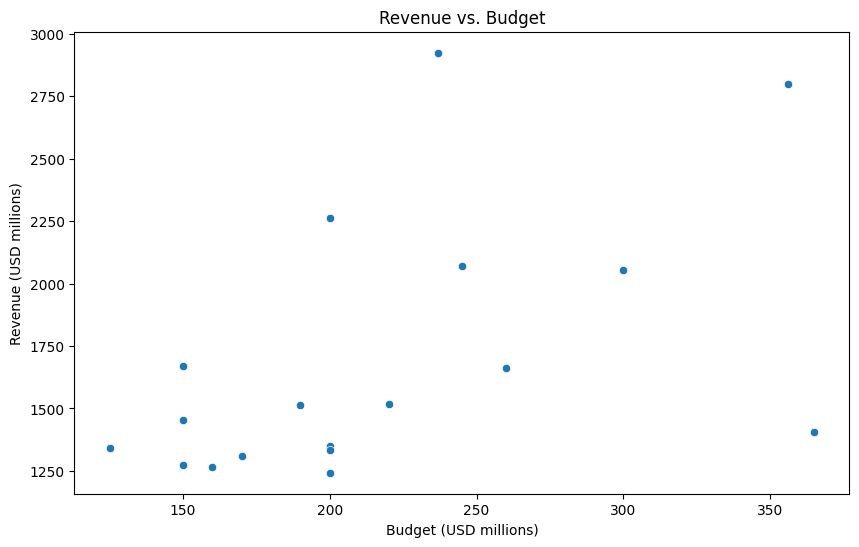

In [74]:
visn.revenue_vs_budget(reordered_df)

- ROI Distribution by Genre

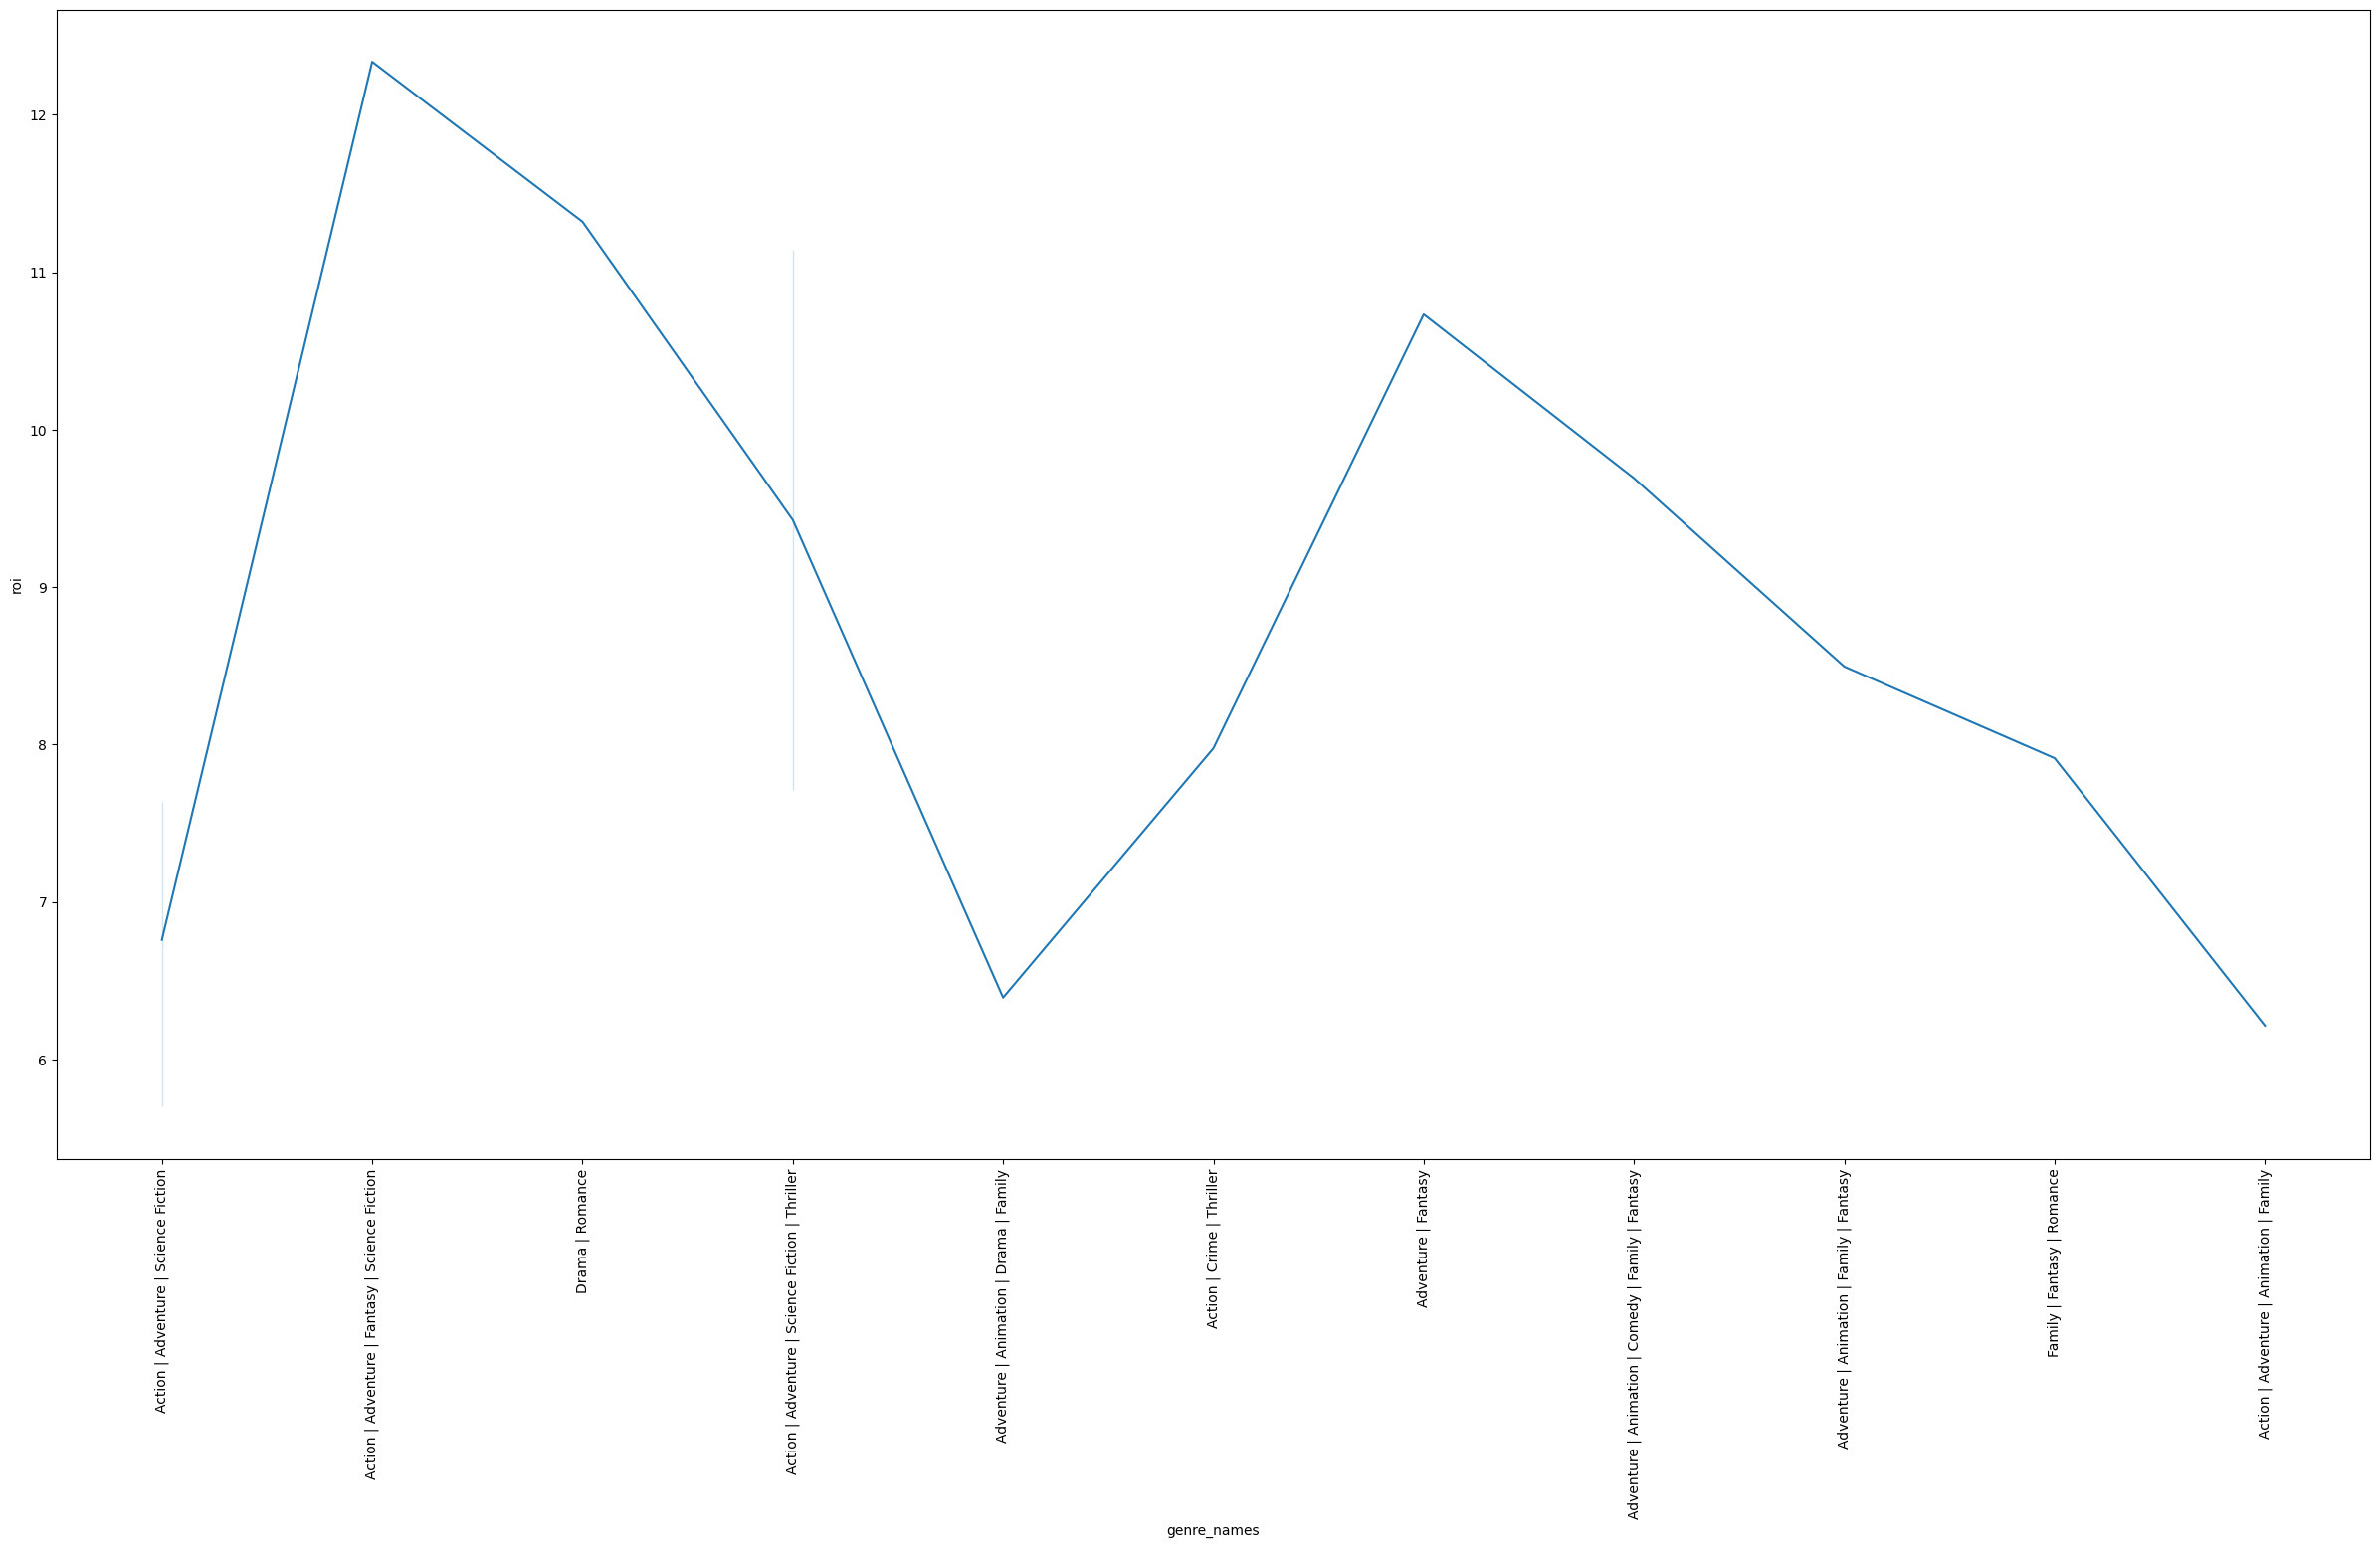

In [75]:
visn.roi_distribution_by_genre(df)

- Popularity vs. Rating

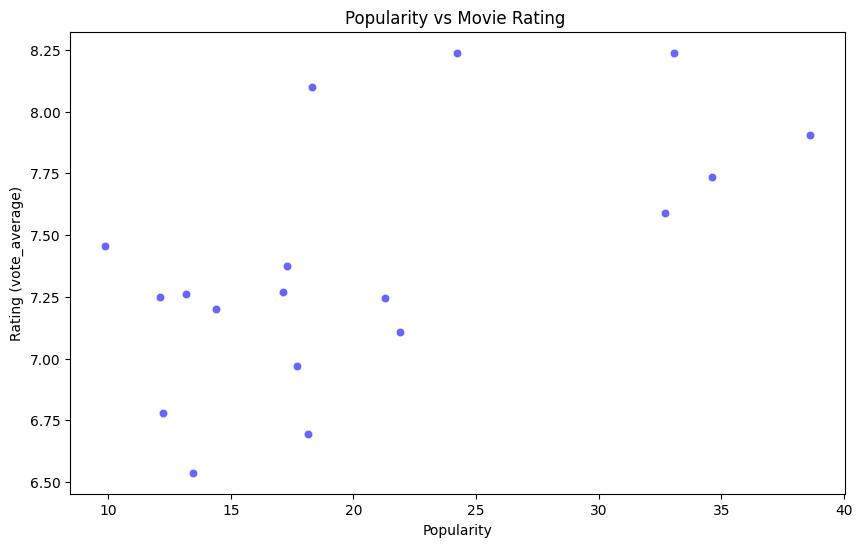

In [76]:
visn.popularity_vs_rating(df)

- Yearly Trends in Box Office Performance

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


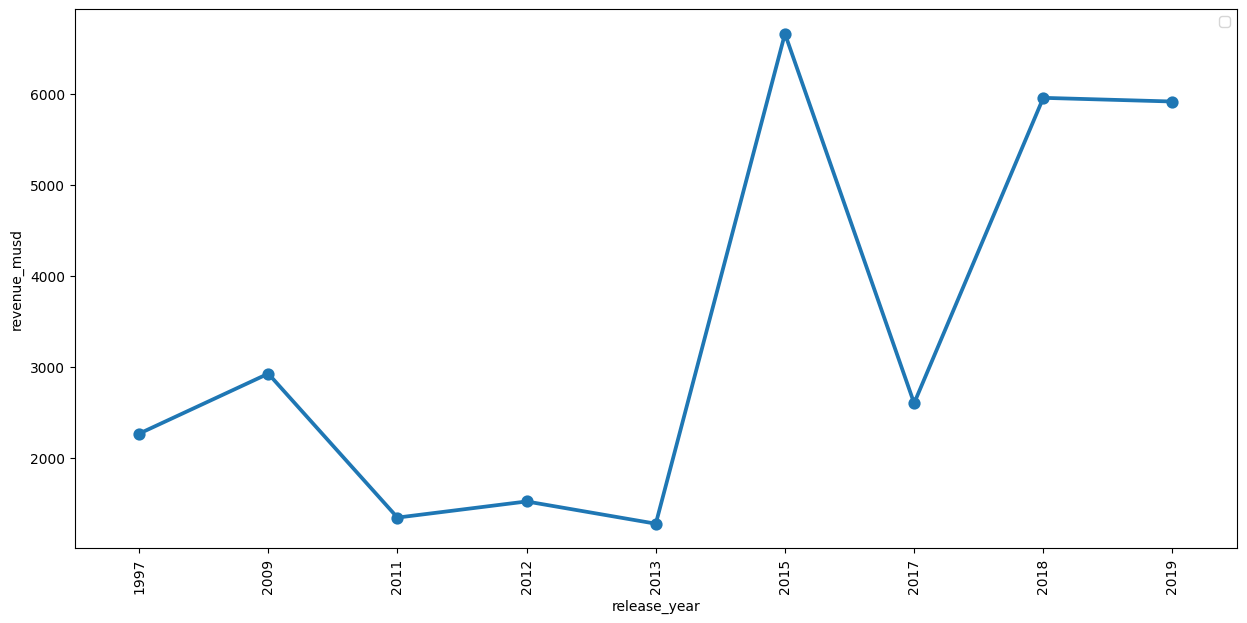

In [77]:
visn.yearly_box_office_performance(df)

- Comparison of Franchise vs. Standalone Success

<Figure size 1000x600 with 0 Axes>

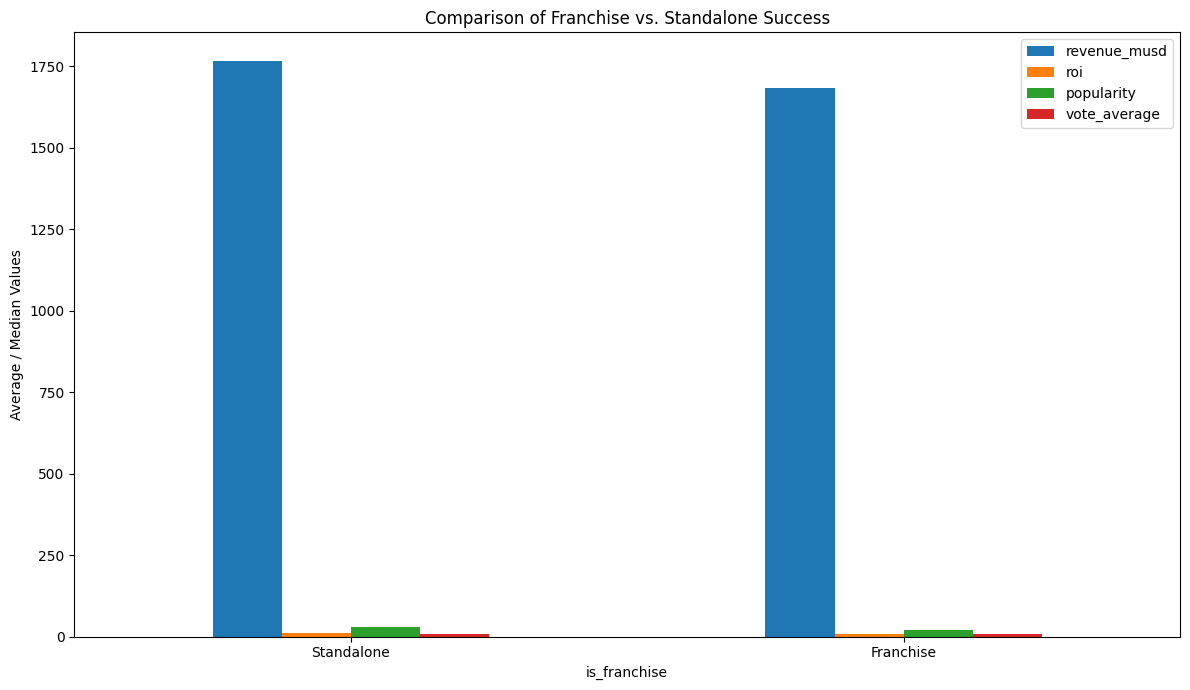

In [78]:
visn.franchise_vs_standalone_success(df)